In [1]:
# This is imported for proper rendering of Latex in Notebook
from IPython.display import display, Math, Latex

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

np.random.seed(306)
plt.style.use('seaborn')

# Linear Regression for Housing Price Prediction

In this notebook, we will build different linear regression models for california house prediction:
1. Linear regression (with normal equation and iterative optimization (SGD))
2. Polynomial regression
3. Regularizarized regression models - Ridge, Lasso, Elastinet

We will set regularization rate and polynomial degree with hyper-parameter tuning and cross-validation.

We will compare different models in terms of their parameter vectors and mean absolute error on train, dev (validation) and test sets.

## Imports

For regression problem, we need to import classes and utilities from `sklearn.linear_model`.
- This module has implementations for different regression models like `LinearRegression`, `SGDRegressor`, `Ridge`, `Lasso`, `RidgeCV` and `LassoCV`

We will also need to import a bunch of model selection utilities from `sklearn.model_selection` module and metrics from `sklearn.metrics` module.

The data preprocessing utilities are imported from `sklearn.preprocessing` modules.

In [3]:
from scipy.stats import loguniform, uniform

from sklearn.datasets import fetch_california_housing

from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV, SGDRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from sklearn.model_selection import cross_validate, cross_val_score, train_test_split, ShuffleSplit, validation_curve, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.pipeline import Pipeline

## Common set up

Set up random seed to a number of your choice.

In [4]:
np.random.seed(306)

Let's use `ShuffleSplit` as cv with 10 splits and 20% examples set aside as test examples.

In [8]:
from sklearn.model_selection import ShuffleSplit

ShuffleSplitCV = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

## Data Loading and splitting

We use the california dataset for this demo. We will load this dataset with `fetch_california_housing` API as a dataframe.

We wil load the data and split it into three parts- train, dev, test. Train + Dev will be used for cross validation and test will be used for evaluating the trained model.

In [7]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

# fetch dataset
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

# train-test split
com_train_features, test_features, com_train_labels, test_labels = train_test_split(features, labels, random_state=42)

# train --> train + dev split
train_features, dev_features, train_labels, dev_labels = train_test_split(com_train_features, com_train_labels, random_state=42)

## Linear regression with Normal Equation

Let's use the normal equation method to train linear regression model.

We set up pipeline with two stages:
- Feature Scaling to scale features and
- Linear regression on the transformed feature matrix.

Throughout this notebook, we will have the following pattern for each estimator:
- We will be using `Pipeline` for combining the data preprocessing and modelling steps.
- `cross_validate` for training the model with `ShuffleSplit` cross validation and `neg_mean_absolute_error` as a scoring metric.
- Convert the scores to error and report the mean absolute errors on the dev set.

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

lin_reg_pipe = Pipeline([
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

lin_reg_cv_results = cross_validate(
    lin_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

lin_reg_train_errors = -1 * lin_reg_cv_results['train_score']
lin_reg_test_errors = -1 * lin_reg_cv_results['test_score']

print(
    f"Mean absolute error of linear regression model on the train set:\n"
    f"{lin_reg_train_errors.mean():.3f} +/- {lin_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of linear regression model on the test set:\n"
    f"{lin_reg_test_errors.mean():.3f} +/- {lin_reg_test_errors.std():.3f}"
)

Mean absolute error of linear regression model on the train set:
0.530 +/- 0.002
Mean absolute error of linear regression model on the test set:
0.527 +/- 0.008


Both the errors are close, but are not low. This points to possible underfitting. We can address it by adding more features through polynomial regression.

## Linear Regression with SGD

Let's use iterative optimization method to train linear regression model.

We set up pipeline with two stages:
- Feature scaling to scale features and
- SGD regression on the transformed feature matrix.

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate

sgd_reg_pipe = Pipeline([
    ('feature_scaler', StandardScaler()),
    ('sgd', SGDRegressor(
        max_iter = np.ceil(1e6/com_train_features.shape[0]),
        early_stopping=True,
        eta0=1e-4,
        learning_rate='constant',
        tol=1e-5,
        validation_fraction=0.1,
        n_iter_no_change=5,
        average=10,
        random_state=42
    ))
])

sgd_reg_cv_results = cross_validate(
    sgd_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv=ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

sgd_reg_train_errors = -1 * sgd_reg_cv_results['train_score']
sgd_reg_test_errors = -1 * sgd_reg_cv_results['test_score']

print(
    f"Mean absolute error of SGD regression model on the train set:\n"
    f"{sgd_reg_train_errors.mean():.3f} +/- {sgd_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of SGD regression model on the test set:\n"
    f"{sgd_reg_test_errors.mean():.3f} +/- {sgd_reg_test_errors.std():.3f}"
)

Mean absolute error of SGD regression model on the train set:
0.564 +/- 0.023
Mean absolute error of SGD regression model on the test set:
0.561 +/- 0.025


## Polynomial Regression

We will train a polynomial model with degree 2 and later we will use `validation_curve` to find out the right degree to use for polynomial models.

`PolynomialFeatures` transforms the features to the user specified degree (here it is 2). We perform feature scaling on the transformed features before using them for training the regression model.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

poly_reg_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

poly_reg_cv_results = cross_validate(
    poly_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

poly_reg_train_errors = -1 * poly_reg_cv_results['train_score']
poly_reg_test_errors = -1 * poly_reg_cv_results['test_score']

print(
    f"Mean absolute error of Polynomial regression model on the train set:\n"
    f"{poly_reg_train_errors.mean():.3f} +/- {poly_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of Polynomial regression model on the test set:\n"
    f"{poly_reg_test_errors.mean():.3f} +/- {poly_reg_test_errors.std():.3f}"
)

Mean absolute error of Polynomial regression model on the train set:
0.461 +/- 0.003
Mean absolute error of Polynomial regression model on the test set:
0.485 +/- 0.030


Notice that the training and validation errors have reduced after using the second order polynomial features to represent the model.

Now, instead of using all the polynomial features, we can also use only the interaction feature terms in polynomial model, by setting `interaction_only=True` in the `PolynomialFeatures` and train the linear regression model over it.

In [97]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

poly_reg_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

poly_reg_cv_results = cross_validate(
    poly_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

poly_reg_train_errors = -1 * poly_reg_cv_results['train_score']
poly_reg_test_errors = -1 * poly_reg_cv_results['test_score']

print(
    f"Mean absolute error of Polynomial regression model on the train set:\n"
    f"{poly_reg_train_errors.mean():.3f} +/- {poly_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of Polynomial regression model on the test set:\n"
    f"{poly_reg_test_errors.mean():.3f} +/- {poly_reg_test_errors.std():.3f}"
)

Mean absolute error of Polynomial regression model on the train set:
0.478 +/- 0.003
Mean absolute error of Polynomial regression model on the test set:
0.497 +/- 0.024


## Hyper Parameter Tuning (HPT) for degree in Polynomial Regression

Let's figure out which degree polynomial is better suited for the regression problem at our hand. For that we will use `validation_curve`, which can be considered as a manual hyperparameter tuning.

Here, we specify a list of values that we want to try for polynomial degree and specify it as a paramter in `validation_curve`.

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import validation_curve

poly_reg_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
    ('feature_scaler', StandardScaler()),
    ('lin_reg', LinearRegression())
])

deg_list = [1,2,3,4,5]

train_scores, test_scores = validation_curve(
    poly_reg_pipe,
    com_train_features,
    com_train_labels,
    param_name='poly__degree',
    param_range=deg_list,
    cv=ShuffleSplitCV,
    scoring='neg_mean_absolute_error',
    n_jobs=2,
)

train_errors, test_errors = -train_scores, -test_scores

In [25]:
type(train_scores)

numpy.ndarray

In [26]:
train_scores

array([[-0.53432327, -0.52950337, -0.52972591, -0.53233173, -0.52827875,
        -0.53088043, -0.52799365, -0.53377084, -0.5269963 , -0.53021738],
       [-0.48141199, -0.47536718, -0.47916492, -0.47930188, -0.47349609,
        -0.47585904, -0.47495801, -0.48228338, -0.47648715, -0.47986468],
       [-0.47737586, -0.45524604, -0.46125937, -0.45971634, -0.45335704,
        -0.45690487, -0.45360118, -0.46528159, -0.45931615, -0.46107595],
       [-0.44797423, -0.44023681, -0.44259801, -0.44601195, -0.43938662,
        -0.44183094, -0.44121656, -0.4482354 , -0.44257338, -0.44484208],
       [-0.44351488, -0.43517237, -0.43651576, -0.44018028, -0.43505328,
        -0.43647782, -0.4346899 , -0.44166875, -0.43677806, -0.44051523]])

Now, we visualize the training and validation errors for various degree and decide on the best degree parameter.

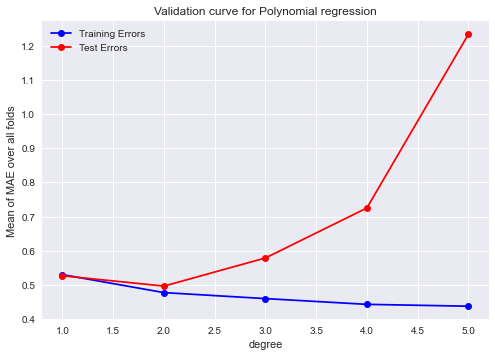

In [27]:
plt.figure()
plt.plot(deg_list, train_errors.mean(axis=1), 'b-o', label="Training Errors")
plt.plot(deg_list, test_errors.mean(axis=1), 'r-o', label="Test Errors")
_ = plt.legend()

plt.xlabel("degree")
plt.ylabel("Mean of MAE over all folds")
plt.title("Validation curve for Polynomial regression")

plt.show()

We would select a degree for which mean absolute error is the least. In this case `degree = 2` yields the least mean absolute error and that would be selected as an optimal degree for polynomial regression.

## Ridge Regression

The polynomial models have a tendency to overfit - if we use higher order polynomial features. We will use `Ridge` regression - which penalizes for excessive model complexity in the polynomial regression by adding a regularization term. Here, we specify the regularization rate `alpha` as `0.5` and train the regression model. Later we will launch the hyperparameter search for the right value of `alpha` such that it leads to the least cross validation errors.

In [88]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_validate

ridge_reg_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('ridge', Ridge(alpha=0.5))
])

ridge_reg_cv_results = cross_validate(
    ridge_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

ridge_reg_train_errors = -1 * ridge_reg_cv_results['train_score']
ridge_reg_test_errors = -1 * ridge_reg_cv_results['test_score']

print(
    f"Mean absolute error of Ridge regression model on the train set:\n"
    f"{ridge_reg_train_errors.mean():.3f} +/- {ridge_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of Ridge regression model on the test set:\n"
    f"{ridge_reg_test_errors.mean():.3f} +/- {ridge_reg_test_errors.std():.3f}"
)

Mean absolute error of Ridge regression model on the train set:
0.481 +/- 0.003
Mean absolute error of Ridge regression model on the test set:
0.487 +/- 0.006


## HPT for Ridge Regularization Rate

### With cross-validation via `RidgeCV`

In [29]:
alpha_list = np.logspace(-4,0, num=20)

In [30]:
alpha_list

array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import RidgeCV

ridge_cv_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('ridge_cv', RidgeCV(
        alphas=alpha_list,
        cv=ShuffleSplitCV,
        scoring='neg_mean_absolute_error'
    ))
])

ridge_cv_results = ridge_cv_pipe.fit(com_train_features, com_train_labels)

print(
    f"The score with best alpha:\n"
    f"{ridge_cv_results[-1].best_score_:.3f}"
)
print(
    f"The error with best alpha:\n"
    f"{-ridge_cv_results[-1].best_score_:.3f}"
)
print(
    f"The best value of alpha:\n"
    f"{ridge_cv_results[-1].alpha_:.3f}"
)

The score with best alpha:
-0.473
The error with best alpha:
0.473
The best value of alpha:
0.008


### With `GridSearchCV`

A more general way of hyperparameter tuning can be via using the `GridSearchCV` method.

It has the following useful attributes - 
- `cv_results_` : dict of numpy (masked) ndarrays : 
        A dict with keys as column headers and values as columns, that can be imported into a pandas `DataFrame`.
- `best_estimator_` : estimator : 
        Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data.
- `best_score_` : float : 
        Mean cross-validated score of the best_estimator
        For multi-metric evaluation, this is present only if `refit` is specified.
- `best_params_` : dict : 
        Parameter setting that gave the best results on the hold out data.
- `best_index_` : int : 
        The index (of the `cv_results_` arrays) which corresponds to the best candidate parameter setting.
        The dict at `search.cv_results_['params'][search.best_index_]` gives the parameter setting for the best model, that gives the highest mean score (`search.best_score_`).

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_grid_pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('feature_scaler', StandardScaler()),
    ('ridge', Ridge())
])

param_grid = {
    'poly__degree' : [1,2,3,4,5],
    'ridge__alpha' : np.logspace(-4,0, num=20),
}

ridge_grid_search = GridSearchCV(
    ridge_grid_pipe,
    param_grid=param_grid,
    n_jobs=2,
    cv=ShuffleSplitCV,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

ridge_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             n_jobs=2,
             param_grid={'poly__degree': [1, 2, 3, 4, 5],
                         'ridge__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00])},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [49]:
print(type(ridge_grid_search.cv_results_))
print(ridge_grid_search.cv_results_.keys())
print(ridge_grid_search.best_params_)
print(ridge_grid_search.best_index_)

<class 'dict'>
dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_poly__degree', 'param_ridge__alpha', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])
{'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}
29


In [50]:
mean_train_error = -1 * ridge_grid_search.cv_results_['mean_train_score'][ridge_grid_search.best_index_]
std_train_error = -1 * ridge_grid_search.cv_results_['std_train_score'][ridge_grid_search.best_index_]
mean_test_error = -1 * ridge_grid_search.cv_results_['mean_test_score'][ridge_grid_search.best_index_]
std_test_error = -1 * ridge_grid_search.cv_results_['std_test_score'][ridge_grid_search.best_index_]

print(
    f"Mean absolute error of Polynomial Ridge regression model on the train set:\n"
    f"{mean_train_error:.3f} +/- {std_train_error.std():.3f}"
)
print(
    f"Mean absolute error of Polynomial Ridge regression model on the test set:\n"
    f"{mean_test_error.mean():.3f} +/- {std_test_error.std():.3f}"
)

Mean absolute error of Polynomial Ridge regression model on the train set:
0.463 +/- 0.000
Mean absolute error of Polynomial Ridge regression model on the test set:
0.474 +/- 0.000


In [51]:
print("Mean cross validated score of the best estimator is: ", ridge_grid_search.best_score_)
print("Mean cross validated error of the best estimator is: ", -ridge_grid_search.best_score_)

Mean cross validated score of the best estimator is: -0.47386511769959316
Mean cross validated error of the best estimator is: 0.47386511769959316


In [52]:
print("The best parameter value is: ", ridge_grid_search.best_params_)

The best parameter value is:  {'poly__degree': 2, 'ridge__alpha': 0.007847599703514606}


Note that the best parameter, and best score obtained here via `GridSearchCV` is the same as the ones that we obtained via Polynomial Regression with `degree=2` on `RidgeCV`.

## Lasso Regression

First, we try a baseline model with a fixed `alpha=0.01`.

In [53]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_validate

lasso_reg_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('lasso', Lasso(alpha=0.01))
])

lasso_reg_cv_results = cross_validate(
    lasso_reg_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

lasso_reg_train_errors = -1 * lasso_reg_cv_results['train_score']
lasso_reg_test_errors = -1 * lasso_reg_cv_results['test_score']

print(
    f"Mean absolute error of lasso regression model on the train set:\n"
    f"{lasso_reg_train_errors.mean():.3f} +/- {lasso_reg_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of lasso regression model on the test set:\n"
    f"{lasso_reg_test_errors.mean():.3f} +/- {lasso_reg_test_errors.std():.3f}"
)

Mean absolute error of lasso regression model on the train set:
0.529 +/- 0.003
Mean absolute error of lasso regression model on the test set:
0.528 +/- 0.008


## HPT for lasso regularization rate

### With cross validation via `LassoCV`

In [54]:
alpha_list = np.logspace(-4,0, num=20)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LassoCV

lasso_cv_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('lasso_cv', LassoCV(
        alphas=alpha_list,
        cv=ShuffleSplitCV
    ))
])

lasso_cv_results = lasso_cv_pipe.fit(com_train_features, com_train_labels)

print(
    f"The best value of alpha:\n"
    f"{lasso_cv_results[-1].alpha_:.3f}"
)

The best value of alpha:
0.008


### With `GridSearchCV`

In [59]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso_grid_pipe = Pipeline([
    ('poly', PolynomialFeatures()),
    ('feature_scaler', StandardScaler()),
    ('lasso', Lasso())
])

param_grid = {
    'poly__degree' : [1,2,3,4,5],
    'lasso__alpha' : np.logspace(-4,0, num=20),
}

lasso_grid_search = GridSearchCV(
    lasso_grid_pipe,
    param_grid=param_grid,
    n_jobs=2,
    cv=ShuffleSplitCV,
    scoring='neg_mean_absolute_error',
    return_train_score=True
)

lasso_grid_search.fit(com_train_features, com_train_labels)

GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('feature_scaler', StandardScaler()),
                                       ('lasso', Lasso())]),
             n_jobs=2,
             param_grid={'lasso__alpha': array([1.00000000e-04, 1.62377674e-04, 2.63665090e-04, 4.28133240e-04,
       6.95192796e-04, 1.12883789e-03, 1.83298071e-03, 2.97635144e-03,
       4.83293024e-03, 7.84759970e-03, 1.27427499e-02, 2.06913808e-02,
       3.35981829e-02, 5.45559478e-02, 8.85866790e-02, 1.43844989e-01,
       2.33572147e-01, 3.79269019e-01, 6.15848211e-01, 1.00000000e+00]),
                         'poly__degree': [1, 2, 3, 4, 5]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [61]:
mean_train_error = -1 * lasso_grid_search.cv_results_['mean_train_score'][lasso_grid_search.best_index_]
std_train_error = -1 * lasso_grid_search.cv_results_['std_train_score'][lasso_grid_search.best_index_]
mean_test_error = -1 * lasso_grid_search.cv_results_['mean_test_score'][lasso_grid_search.best_index_]
std_test_error = -1 * lasso_grid_search.cv_results_['std_test_score'][lasso_grid_search.best_index_]

print(
    f"Mean absolute error of Polynomial lasso regression model on the train set:\n"
    f"{mean_train_error:.3f} +/- {std_train_error.std():.3f}"
)
print(
    f"Mean absolute error of Polynomial lasso regression model on the test set:\n"
    f"{mean_test_error.mean():.3f} +/- {std_test_error.std():.3f}"
)

Mean absolute error of Polynomial lasso regression model on the train set:
0.449 +/- 0.000
Mean absolute error of Polynomial lasso regression model on the test set:
0.474 +/- 0.000


In [62]:
print("Mean cross validated score of the best estimator is: ", lasso_grid_search.best_score_)
print("Mean cross validated error of the best estimator is: ", -lasso_grid_search.best_score_)

Mean cross validated score of the best estimator is:  -0.4735026141130332
Mean cross validated error of the best estimator is:  0.4735026141130332


In [63]:
print("The best parameter value is: ", lasso_grid_search.best_params_)

The best parameter value is:  {'lasso__alpha': 0.00026366508987303583, 'poly__degree': 5}


## SGD: Regularization and HPT

We can also perdorm regularization with SGD. `SGDRegressor` has many hyperparameters that require careful tuning to achieve the same performace as with `LinearRegression`, Normal Equation method.

### Baseline SGD model

In [65]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_validate

poly_sgd_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('sgd_reg', SGDRegressor(
        penalty='elasticnet',
        random_state=42
    ))
])

poly_sgd_cv_results = cross_validate(
    poly_sgd_pipe,
    com_train_features,
    com_train_labels,
    scoring='neg_mean_absolute_error',
    cv = ShuffleSplitCV,
    return_train_score=True,
    return_estimator=True
)

poly_sgd_train_errors = -1 * poly_sgd_cv_results['train_score']
poly_sgd_test_errors = -1 * poly_sgd_cv_results['test_score']

print(
    f"Mean absolute error of Polynomial regression model on the train set:\n"
    f"{poly_sgd_train_errors.mean():.3f} +/- {poly_sgd_train_errors.std():.3f}"
)
print(
    f"Mean absolute error of Polynomial regression model on the test set:\n"
    f"{poly_sgd_test_errors.mean():.3f} +/- {poly_sgd_test_errors.std():.3f}"
)

Mean absolute error of Polynomial regression model on the train set:
10824283052.546 +/- 4423288211.832
Mean absolute error of Polynomial regression model on the test set:
10946788540.250 +/- 5396536227.703


### SGD via `RandomizedSearchCV`

Let's search the best set of parameters for polynomial + SGD pipeline with `RandomizedSearchCV`.

> Note: In `RandomizedSearchCV`, we need to specify distributions for hyperparameters.

In [64]:
class uniform_int:
    '''Integer valued version of the uniform distribution'''
    def __init__(self, a, b):
        self._distribution = uniform(a,b)
    
    def rvs(self, *args, **kwargs):
        '''Random Variable Sample'''
        return self._distribution.rvs(*args, **kwargs).astype(int)

Let's specify `RandomSearchCV` setup.

Here, `n_jobs=10`, is a way of controlling the budget or the time that we spend in performing the parameter search. So, after 10 iterations performed by `RandomSearchCV`, we get the best possible parameters. Obviously, going through larger no. of iterations gives us a higher chance of hitting the optimum set of parameters.

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import RandomizedSearchCV

poly_sgd_pipe = Pipeline([
    ('poly', PolynomialFeatures(degree=2)),
    ('feature_scaler', StandardScaler()),
    ('sgd_reg', SGDRegressor(
        penalty='elasticnet',
        random_state=42
    ))
])

param_distributions = {
    'poly__degree': [1,2,3],
    'sgd_reg__learning_rate': ['constant', 'adaptive', 'invscaling'],
    'sgd_reg__l1_ratio': uniform(0,1),
    'sgd_reg__eta0': loguniform(1e-5, 1),
    'sgd_reg__power_t': uniform(0,1)
}

poly_sgd_random_search = RandomizedSearchCV(
    poly_sgd_pipe,
    param_distributions=param_distributions,
    n_iter=10,
    cv=ShuffleSplitCV,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-2,
)

poly_sgd_random_search.fit(com_train_features, com_train_labels)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
                   estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                             ('feature_scaler',
                                              StandardScaler()),
                                             ('sgd_reg',
                                              SGDRegressor(penalty='elasticnet',
                                                           random_state=42))]),
                   n_jobs=-2,
                   param_distributions={'poly__degree': [1, 2, 3],
                                        'sgd_reg__eta0': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fded1379be0>,
                                        'sgd_reg__l1_ratio': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fdf032a1550>,
                                        'sgd_reg__learning_rate': ['constant',
                                        

The best score can be obtained as follows:

In [68]:
poly_sgd_random_search.best_score_

-0.5299969639195103

In [69]:
poly_sgd_random_search.best_params_

{'poly__degree': 2,
 'sgd_reg__eta0': 2.2259378986364428e-05,
 'sgd_reg__l1_ratio': 0.8822531810873846,
 'sgd_reg__learning_rate': 'constant',
 'sgd_reg__power_t': 0.8805394810951347}

And the best estimator can be accessed via the `best_estimator_` variable.

## Comparison of Weight Vectors

Let's look at the weight vectors produced by different models.

### Polynomial Regression

In [78]:
feature_names = poly_reg_cv_results['estimator'][0][0].get_feature_names(input_features=train_features.columns)
np.transpose(np.array(feature_names))

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge AveRooms', 'HouseAge AveBedrms', 'HouseAge Population',
       'HouseAge AveOccup', 'HouseAge Latitude', 'HouseAge Longitude',
       'AveRooms AveBedrms', 'AveRooms Population', 'AveRooms AveOccup',
       'AveRooms Latitude', 'AveRooms Longitude', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup Latitude', 'AveOccup Longitude',
       'Latitude Longitude'], dtype='<U20')

In [79]:
coefs = [est[-1].coef_ for est in poly_reg_cv_results['estimator']]
weights_polynomial_regression = pd.DataFrame(coefs, columns=feature_names)

<Figure size 576x396 with 0 Axes>

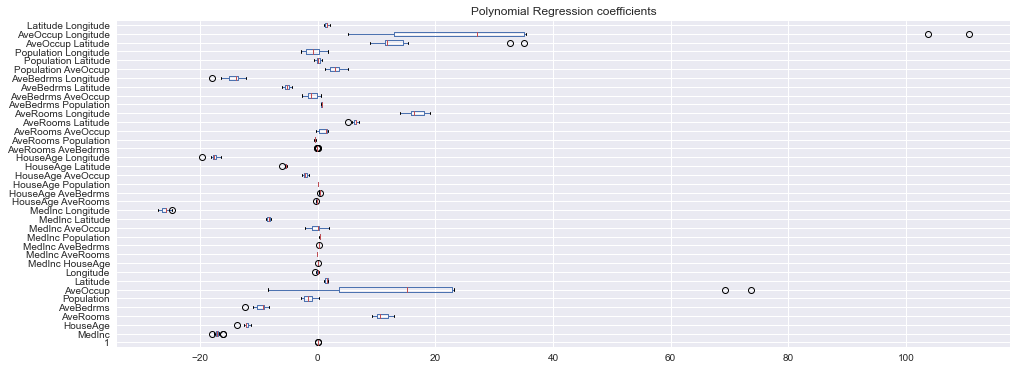

In [83]:
plt.figure()
weights_polynomial_regression.plot.box(figsize=(16,6), vert=False)
plt.title("Polynomial Regression coefficients")
plt.show()

### Polynomial Ridge Regression

In [89]:
feature_names = ridge_reg_cv_results['estimator'][0][0].get_feature_names(input_features=train_features.columns)
np.transpose(np.array(feature_names))

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype='<U20')

In [90]:
coefs = [est[-1].coef_ for est in ridge_reg_cv_results['estimator']]
weights_ridge_regression = pd.DataFrame(coefs, columns=feature_names)

<Figure size 576x396 with 0 Axes>

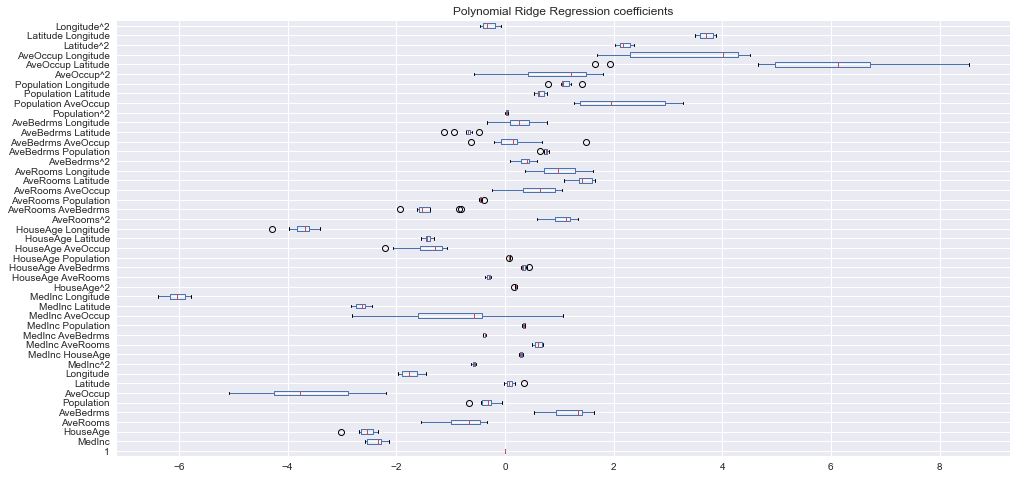

In [93]:
plt.figure()
weights_ridge_regression.plot.box(figsize=(16,8), vert=False)
plt.title("Polynomial Ridge Regression coefficients")
plt.show()

## Performance on the Test Set

### Baseline

In [94]:
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_percentage_error

baseline_model_median = DummyRegressor(strategy='median')
baseline_model_median.fit(com_train_features, com_train_labels)
mean_absolute_percentage_error(
    test_labels, 
    baseline_model_median.predict(test_features)
)

0.5329666796008011

### Linear Regression with Normal Equation

In [95]:
mean_absolute_percentage_error(
    test_labels, 
    lin_reg_cv_results['estimator'][0].predict(test_features)
)

0.32120472175482895

### Polynomial SGD Regressor via `RandomizedSearchCV`

In [96]:
mean_absolute_percentage_error(
    test_labels, 
    poly_sgd_random_search.best_estimator_.predict(test_features)
)

0.3152640292637166

### Polynomial Regression

In [98]:
# cell 21 - polynomial regression without interaction
poly_reg_pipe.fit(com_train_features, com_train_labels)

mean_absolute_percentage_error(
    test_labels, 
    poly_reg_pipe.predict(test_features)
)

0.28199759082656944

### Ridge Regression via `GridSearchCV`

In [99]:
mean_absolute_percentage_error(
    test_labels, 
    ridge_grid_search.best_estimator_.predict(test_features)
)

0.2711033645139322

### Lasso Regression via `GridSearchCV`

In [100]:
mean_absolute_percentage_error(
    test_labels, 
    lasso_grid_search.best_estimator_.predict(test_features)
)

0.2812589416961285

## Summary

We trained multiple linear regression models on the `California Housing Dataset`.

We set their hyperparameters through hyperparameter searching and optimizations.

We retrained models with their best values of hyperparameters and then evaluated their performance on the test data (which was held back till the end for fair evaluation).

This is how most of the real world problems are solved starting from simple to more sophisticated models.